# Наша первая свёрточная нейросеть 

Пришло время построить нашу первую свёрточную нейросеть. Будем использовать для этого датасет [fashion MNIST.](https://www.cs.toronto.edu/~kriz/cifar.html) 

In [1]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [3]:
from tensorflow.keras import Sequential
keras, L = tf.keras, tf.keras.layers

import numpy as np
import random
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Смотрим на данные 

Скачаеми приготовим данные. Буквально через минуту в наших руках окажутся $60 000$ картинок размера $28 \times 28$.

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Отнормировали данные к отрезку [0;1]
X_train = X_train/ 255.
X_test = X_test/ 255.

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
print("Train samples:", X_train.shape, y_train.shape)
print("Test samples:", X_test.shape, y_test.shape)

Train samples: (60000, 28, 28) (60000,)
Test samples: (10000, 28, 28) (10000,)


Нарисуем несколько рандомных картинок из тренировочной выборки. 

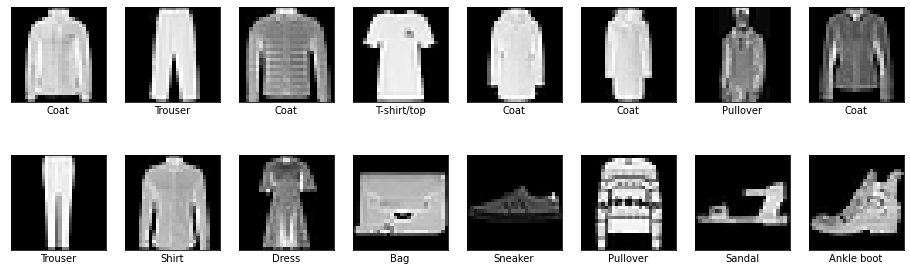

In [6]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(X_train[random_index, :], cmap = 'gray')
        ax.set_xlabel(class_names[y_train[random_index]])
plt.show()

## 2.  Выбираем для нашей нейросети архитектуру

Свёрточная нейронная сеть строится из нескольких разных типов слоёв: 

* [Conv2D](https://keras.io/layers/convolutional/#conv2d) - Конволюция:
    - **filters**: число выходных каналов; 
    - **kernel_size**: размер окна для свёртки;
    - **padding**: padding="same" добавляет нулевую каёмку по краям картинки, чтбы после свёртки размеры картинки не изменялись; padding='valid' ничего не добавляет;
    - **activation**: "relu", "tanh", etc.
    - **input_shape**: размер входа
* [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - макспулинг
* [Flatten](https://keras.io/layers/core/#flatten) - разворачивает картинку в вектор 
* [Dense](https://keras.io/layers/core/#dense) - полносвязный слой (fully-connected layer)
* [Activation](https://keras.io/layers/core/#activation) - функция активации
* [LeakyReLU](https://keras.io/layers/advanced-activations/#leakyrelu) - leaky relu активация
* [Dropout](https://keras.io/layers/core/#dropout) - дропаут.


В модели, которую мы определим ниже, на вход будет идти тензоры размера __(None, 28, 28, 1)__ и __(None, 10)__. На выходе мы будем получать вероятноть того, что объект относится к конкретному классу. Разменость __None__ заготовлена для размерности батча. 

## 2.1 Полносвязная сетка 

Соберём полносвязную сетку с нашей предыдущей пары/ 

In [7]:
tf.random.set_seed(42)

model_1 = Sequential( )

model_1.add(L.Flatten(input_shape=(28, 28)))

model_1.add(L.Dense(64))
model_1.add(L.BatchNormalization()) 
model_1.add(L.Activation('relu'))

model_1.add(L.Dense(32))
model_1.add(L.BatchNormalization()) 
model_1.add(L.Activation('relu'))

model_1.add(L.Dense(16))
model_1.add(L.BatchNormalization()) 
model_1.add(L.Activation('relu'))

model_1.add(L.Dense(10, activation='softmax'))

model_1.compile("adam", "sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

hist = model_1.fit(X_train, y_train, validation_split= 0.2,
                        batch_size=500, epochs=10, verbose=1)

Epoch 1/10
96/96 [==============================] - 2s 10ms/step - loss: 1.2307 - sparse_categorical_accuracy: 0.7029 - val_loss: 1.2345 - val_sparse_categorical_accuracy: 0.8023
Epoch 2/10
96/96 [==============================] - 1s 7ms/step - loss: 0.6526 - sparse_categorical_accuracy: 0.8447 - val_loss: 0.7160 - val_sparse_categorical_accuracy: 0.8403
Epoch 3/10
96/96 [==============================] - 1s 7ms/step - loss: 0.4663 - sparse_categorical_accuracy: 0.8673 - val_loss: 0.5092 - val_sparse_categorical_accuracy: 0.8442
Epoch 4/10
96/96 [==============================] - 1s 8ms/step - loss: 0.3891 - sparse_categorical_accuracy: 0.8783 - val_loss: 0.4630 - val_sparse_categorical_accuracy: 0.8404
Epoch 5/10
96/96 [==============================] - 1s 9ms/step - loss: 0.3473 - sparse_categorical_accuracy: 0.8859 - val_loss: 0.4503 - val_sparse_categorical_accuracy: 0.8462
Epoch 6/10
96/96 [==============================] - 1s 8ms/step - loss: 0.3193 - sparse_categorical_accuracy:

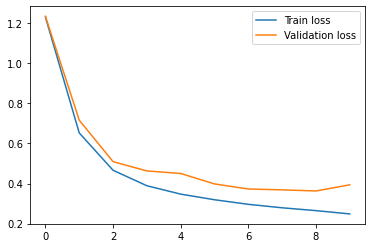

In [8]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])

In [9]:
print("\nLoss, Accuracy = ", model_1.evaluate(X_test, y_test, verbose=0))


Loss, Accuracy =  [0.4109528362751007, 0.8572999835014343]


Можно посмотреть, где именно сетка ошибается. 

In [10]:
y_pred = np.argmax(model_1.predict(X_test), axis=1)
errors = y_pred != y_test

# срежем только наблюдения, где была ошибка вместе с метками
X_err = X_test[errors]
y_err = y_test[errors]
y_pred = y_pred[errors]

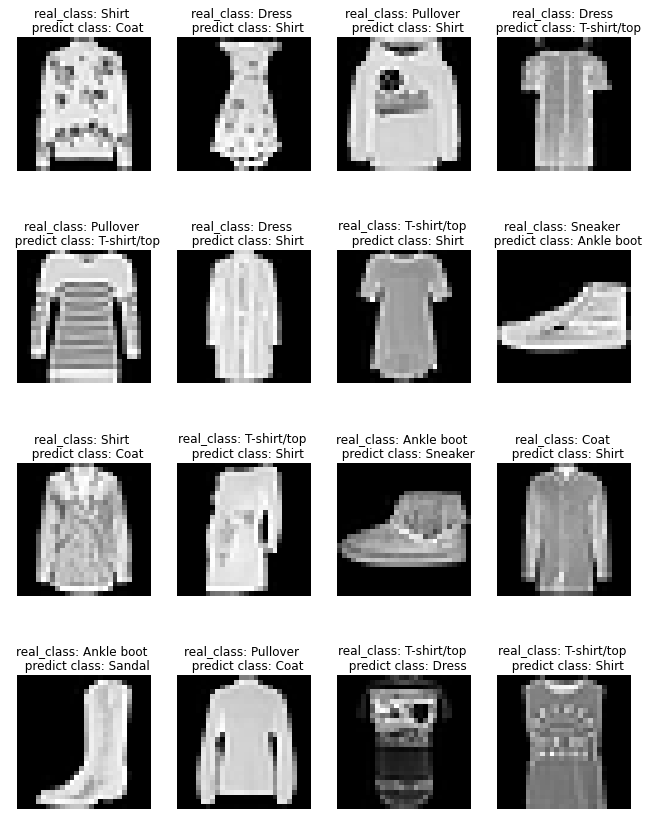

In [11]:
cols = 4
rows = 4
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_err[random_index, : ], cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(class_names[y_err[random_index]], 
                                                                   class_names[y_pred[random_index]]))
plt.show()

## 2.2 Свёрточная сетка 

Во-первых, нужно в явном виде указать, что у нас в изображениях один канал. Иначе питон будет ругаться.

In [12]:
X_train.shape

(60000, 28, 28)

In [13]:
X_train[:,:,:,np.newaxis].shape

(60000, 28, 28, 1)

In [14]:
X_train = X_train[:,:,:,np.newaxis]
X_test = X_test[:,:,:,np.newaxis]

Теперь давайте соберём свёртоную сеть: 

* Свёртка с ядром $5 \times 5$, same padding и $32$ каналами
* ReLU
* Макспулинг размера $2 \times 2$
* Свёртка с ядром $5 \times 5$ и $16$ каналами  и valid padding
* ReLU
* Макспулинг размера $2 \times 2$ с шагом (strides) $2$ по обеим осям 
* Дальше сделайте `Flatten` и сделайте два полносвязных слоя с ReLU и $120$ и $60$ нейронами

In [16]:
tf.random.set_seed(42)

model_2 = keras.Sequential()

model_2.add(L.Conv2D(kernel_size=(5, 5), filters=32, padding='same', input_shape=(28,28,1)))
model_2.add(L.ReLU())
model_2.add(L.MaxPool2D(pool_size=(2,2)))

model_2.add(L.Conv2D(kernel_size=(5, 5), filters=16, padding='same')) 
model_2.add(L.ReLU())
model_2.add(L.MaxPool2D(pool_size=(2,2), strides=(2, 2)))

model_2.add(L.Flatten())

model_2.add(L.Dense(units=120, activation='relu'))

model_2.add(L.Dense(units=60, activation='relu'))

model_2.add(L.Dense(units=10, activation = 'softmax'))

model_2.compile("adam", "sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

In [17]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 16)        12816     
_________________________________________________________________
re_lu_3 (ReLU)               (None, 14, 14, 16)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)              

In [18]:
hist = model_2.fit(X_train, y_train, validation_split= 0.2,
                        batch_size=500, epochs=10, verbose=1)

Epoch 1/10
96/96 [==============================] - 54s 553ms/step - loss: 0.8531 - sparse_categorical_accuracy: 0.6983 - val_loss: 0.5520 - val_sparse_categorical_accuracy: 0.7898
Epoch 2/10
96/96 [==============================] - 48s 503ms/step - loss: 0.4882 - sparse_categorical_accuracy: 0.8221 - val_loss: 0.4487 - val_sparse_categorical_accuracy: 0.8413
Epoch 3/10
96/96 [==============================] - 50s 524ms/step - loss: 0.4149 - sparse_categorical_accuracy: 0.8500 - val_loss: 0.4086 - val_sparse_categorical_accuracy: 0.8529
Epoch 4/10
96/96 [==============================] - 55s 565ms/step - loss: 0.3778 - sparse_categorical_accuracy: 0.8655 - val_loss: 0.3763 - val_sparse_categorical_accuracy: 0.8671
Epoch 5/10
96/96 [==============================] - 59s 612ms/step - loss: 0.3452 - sparse_categorical_accuracy: 0.8755 - val_loss: 0.3545 - val_sparse_categorical_accuracy: 0.8748
Epoch 6/10
96/96 [==============================] - 53s 558ms/step - loss: 0.3245 - sparse_cate

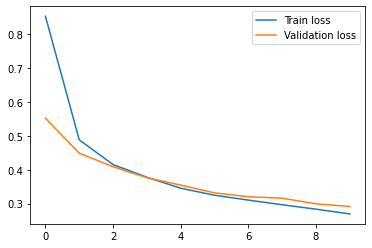

In [19]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])

In [20]:
print("\nLoss, Accuracy = ", model_2.evaluate(X_test, y_test, verbose=0))


Loss, Accuracy =  [0.31221675872802734, 0.8881000280380249]


Как видите, точность выросла

In [21]:
X_test.shape

(10000, 28, 28, 1)

In [22]:
np.squeeze(X_test, axis=3).shape

(10000, 28, 28)

In [23]:
y_pred = np.argmax(model_2.predict(X_test), 1)
errors =  y_pred != y_test

X_err = np.squeeze(X_test[errors], axis=3)
y_err = y_test[errors]
y_pred = y_pred[errors]

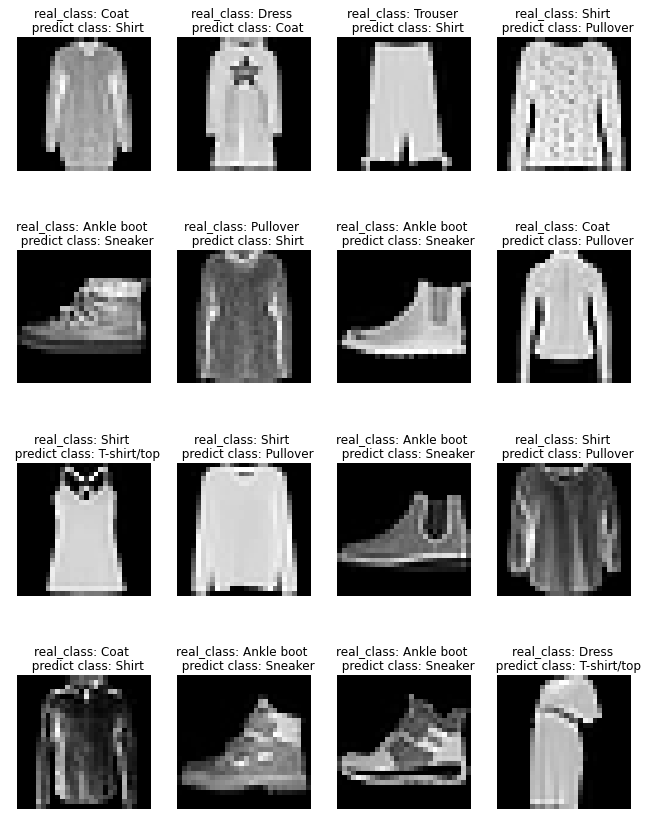

In [24]:
cols = 4
rows = 4
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_err[random_index, : ], cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(class_names[y_err[random_index]], 
                                                                   class_names[y_pred[random_index]]))
plt.show()

## 3.  Data augmentation

Попробуем обучить ту же модель, но искуственно расширяя набор данных за счёт [случайных искажений.](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/)

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* `rotation_range`  значение в градусах (0-180), диапазон, в пределах которого произвольно вращаются изображения;
* `width_shift` и `height_shift` это диапазоны (в долях от общей ширины или высоты), в пределах которых можно произвольно сдвигать изображения по вертикали или горизонтали;
* `zoom_range` для случайного масштабирования внутри фотографий
* `horizontal_flip` для переворачивания половины изображения по горизонтали
* `fill_mode` стратегия для заполнения вновь появившихся пикселей

In [26]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
        )

In [27]:
datagen.fit(X_train) # обучили генератор 

Если обучить нейронку с использованием этих настроек, она никогда не увидит одно и то же изображение дважды. Однако входные данные по-прежнему будут довольно сильно связаны между собой. Мы пытаемся исказить уже существующие объекты так, чтобы они всё ещё оставались собой, но нейронка не выучивала детали, присущие конкретным наблюдениям, то есть __не переобучалась.__ 

In [83]:
# Настраиваем поток данных 
# Возьмём одну картинку 10 раз и подадим её на вход
it = datagen.flow(np.array(10*[X_train[200]]), np.array(10*[y_train[200]]), batch_size=64) # итератор 

images, categories = it.next()
print("Number of images returned by iterator:", len(images))

Number of images returned by iterator: 10


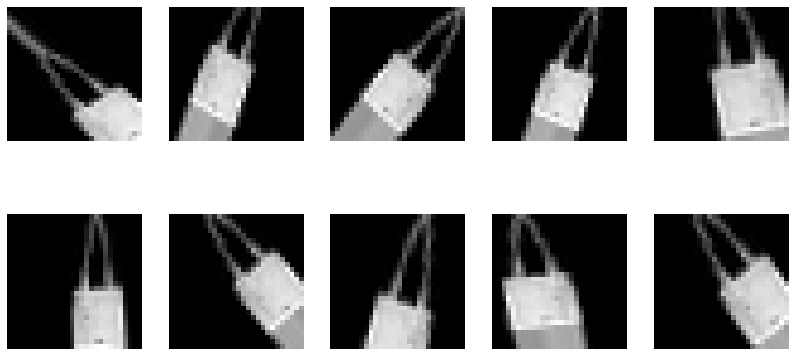

In [30]:
cols = 5
rows = 2
k = 0

fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        im = np.squeeze(images[k], axis=2)
        k += 1
        
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(im, cmap='gray')

plt.show()

Настроим поток для всей выборки. Каждая картинка будет искажаться один раз и подаваться на вход в нейронку. 

In [86]:
# Кусочек откусываем для валидации
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2)

it = datagen.flow(X_tr, y_tr, batch_size=512)

Скопируем сетку из предыдущего пункта. 

In [87]:
model_3 = keras.Sequential()

model_3.add(L.Conv2D(kernel_size=(5, 5), filters=32, padding='same', input_shape=(28,28,1)))
model_3.add(L.ReLU())
model_3.add(L.MaxPool2D(pool_size=(2,2)))

model_3.add(L.Conv2D(kernel_size=(5, 5), filters=16, padding='same')) 
model_3.add(L.ReLU())
model_3.add(L.MaxPool2D(pool_size=(2,2), strides=(2, 2)))

model_3.add(L.Flatten())

model_3.add(L.Dense(units=120, activation='relu'))

model_3.add(L.Dense(units=60, activation='relu'))

model_3.add(L.Dense(units=10, activation = 'softmax'))

model_3.compile("adam", "sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

Обучим сетку. Для этого будем использовать метод `fit_generator`. Так как данные генерируются до бесконечности, модель должна знать сколько образцов надо извлечь перед тем как закончить эпоху. За это отвечает параметр `steps_per_epoch`. После извлечения из генератора `steps_per_epoch` батчей сетка переходит к новой эпохе.

In [89]:
hist = model_3.fit_generator(
    it,
    steps_per_epoch=X_train.shape[0] // 512,
    epochs=10,
    validation_data=(X_val, y_val),
    verbose=1
)

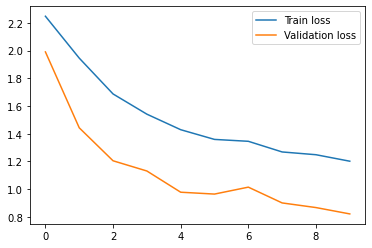

In [34]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])

In [35]:
print("Loss, Accuracy = ", model_3.evaluate(X_test, y_test, verbose=0))

Loss, Accuracy =  [0.8379276394844055, 0.6931999921798706]


Такую сетку надо учить подольше. В этой тетрадке она реализована просто как пример аугментации данных. Побиться за реальное улучшение качества вам предстоит в следующих домишних заданиях 

## Homework
1. Попробовать разные архитектуры сети. Изменить кол-во слоев, параметры слоев, batchsize, кол-во эпох обучения, оптимизаторы
2. Построить сетку с Accuracy на test-выборке >90%


In [90]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2)

it = datagen.flow(X_tr, y_tr, batch_size=512)

In [117]:
model_3 = keras.Sequential()

model_3.add(L.Conv2D(kernel_size=(3, 3), filters=32, padding='same', input_shape=(28,28,1), kernel_initializer='he_uniform'))
model_3.add(L.ReLU())
model_3.add(L.BatchNormalization())
model_3.add(L.Conv2D(kernel_size=(3, 3), filters=32, padding='same', input_shape=(28,28,1), kernel_initializer='he_uniform'))
model_3.add(L.ReLU())
model_3.add(L.BatchNormalization())
model_3.add(L.MaxPool2D(pool_size=(2,2)))
model_3.add(L.Dropout(0.2))

# model_3.add(L.Conv2D(kernel_size=(5, 5), filters=32, padding='same', kernel_initializer='he_uniform'))
# model_3.add(L.BatchNormalization())
# model_3.add(L.LeakyReLU())
# model_3.add(L.MaxPool2D(pool_size=(2,2)))

model_3.add(L.Conv2D(kernel_size=(3, 3), filters=64, padding='same', kernel_initializer='he_uniform'))
model_3.add(L.ReLU())
model_3.add(L.BatchNormalization())
model_3.add(L.Conv2D(kernel_size=(3, 3), filters=64, padding='same', input_shape=(28,28,1), kernel_initializer='he_uniform'))
model_3.add(L.ReLU())
model_3.add(L.BatchNormalization())
model_3.add(L.MaxPool2D(pool_size=(2,2), strides=(2, 2)))
model_3.add(L.Dropout(0.2))

# model_3.add(L.Conv2D(kernel_size=(3, 3), filters=128, padding='same', kernel_initializer='he_uniform'))
# #model_3.add(L.BatchNormalization())
# model_3.add(L.LeakyReLU())
# model_3.add(L.MaxPool2D(pool_size=(2,2)))

model_3.add(L.Flatten())

model_3.add(L.Dense(units=256, activation='relu', kernel_initializer='he_uniform'))
model_3.add(L.BatchNormalization())
model_3.add(L.Dropout(0.2))

#model_3.add(L.Dropout(0.2))
model_3.add(L.Dense(units=64, activation='relu', kernel_initializer='he_uniform'))
model_3.add(L.BatchNormalization())
model_3.add(L.Dropout(0.3))

model_3.add(L.Dense(units=10, activation = 'softmax'))

model_3.compile("adam", "sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

In [119]:
hist = model_3.fit_generator(
    it,
    steps_per_epoch=40,
    epochs=150,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/150
40/40 [==============================] - 82s 2s/step - loss: 1.5984 - sparse_categorical_accuracy: 0.4377 - val_loss: 1.5887 - val_sparse_categorical_accuracy: 0.4027
Epoch 2/150
40/40 [==============================] - 74s 2s/step - loss: 1.1713 - sparse_categorical_accuracy: 0.5760 - val_loss: 1.5463 - val_sparse_categorical_accuracy: 0.5031
Epoch 3/150
40/40 [==============================] - 75s 2s/step - loss: 1.0066 - sparse_categorical_accuracy: 0.6275 - val_loss: 1.2744 - val_sparse_categorical_accuracy: 0.5388
Epoch 4/150
40/40 [==============================] - 76s 2s/step - loss: 0.9018 - sparse_categorical_accuracy: 0.6713 - val_loss: 0.9626 - val_sparse_categorical_accuracy: 0.6420
Epoch 5/150
40/40 [==============================] - 74s 2s/step - loss: 0.8453 - sparse_categorical_accuracy: 0.6915 - val_loss: 0.9726 - val_sparse_categorical_accuracy: 0.6392
Epoch 6/150
40/40 [==============================] - 75s 2s/step - loss: 0.7779 - sparse_categorical_accu

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "N:\Conda_asus\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-119-e6f8e79fd9f2>", line 1, in <module>
    hist = model_3.fit_generator(
  File "C:\Users\asus\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py", line 1943, in fit_generator
    return self.fit(
  File "C:\Users\asus\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py", line 1183, in fit
    tmp_logs = self.train_function(iterator)
  File "C:\Users\asus\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 889, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\asus\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\eager\def_function.py", line 917, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
 

TypeError: object of type 'NoneType' has no len()

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])

In [ ]:
print("Loss, Accuracy = ", model_3.evaluate(X_test, y_test, verbose=0))

In [ ]:
#0.782